# T1 Mapping from MP2RAGE

Here, I create an example T1 mapping from an MP2RAGE sequence. I used example data from the [CEREBRUM-7T dataset](https://openneuro.org/datasets/ds003642/versions/1.1.0/download). I mostly followed the example from the pymp2rage package, specifically [this file](https://github.com/Gilles86/pymp2rage/blob/master/examples/MP2RAGE%20and%20T1%20fitting.ipynb).

## Edits to pymp2rage
The data provided by CEREBRUM-7T is only magnitude data. The original MP2RAGE paper describes a formula for working with real-valued data. However, the pymp2rage package requires phase and magnitude data.

To solve this issue, I edited the package slightly to allow for real-valued data.

`mp2rage.py` (lines 117-119):
```python
# Normalize phases between 0 and 2 pi
self.inv1ph = image.math_img('((x - np.max(x))/ - np.ptp(x)) * 2 * np.pi', x=self.inv1ph)
self.inv2ph = image.math_img('((x - np.max(x))/ - np.ptp(x)) * 2 * np.pi', x=self.inv2ph)
```

Edited to add code for when `inv1ph` and `inv2ph` aren't defined:
```python
if inv1ph is not None and inv2ph is not None:
    self.inv1ph = image.math_img('((x - np.max(x))/ - np.ptp(x)) * 2 * np.pi', x=self.inv1ph)
    self.inv2ph = image.math_img('((x - np.max(x))/ - np.ptp(x)) * 2 * np.pi', x=self.inv2ph)
else:
    self.inv1ph = None
    self.inv2ph = None
```

`mp2rage.py` (line 153):
```python
def r1(self):
```

Edited to rename to t1 (likely a typo in original):
```python
def t1(self):
```

`mp2rage.py` (lines 159-164):
```python
def fit_t1w_uni(self):
    compINV1 = self.inv1.get_data() * np.exp(self.inv1ph.get_data() * 1j)
    compINV2 = self.inv2.get_data() * np.exp(self.inv2ph.get_data() * 1j)

    # Scale to 4095
    self._t1w_uni = (np.real(compINV1*compINV2/(compINV1**2 + compINV2**2)))*4095+2048
```

Edited to calculate T1 map when phase isn't given:
```python
def fit_t1w_uni(self):
    if self.inv1ph is not None and self.inv2ph is not None:
        compINV1 = self.inv1.get_data() * np.exp(self.inv1ph.get_data() * 1j)
        compINV2 = self.inv2.get_data() * np.exp(self.inv2ph.get_data() * 1j)

        # Scale to 4095
        self._t1w_uni = (np.real(compINV1*compINV2/(compINV1**2 + compINV2**2)))*4095+2048
    else:
        inv1 = self.inv1.get_fdata()
        inv2 = self.inv2.get_fdata()

        # Scale to 4095
        self._t1w_uni = (inv1*inv2/(inv1**2 + inv2**2))*4095+2048
```

## Import packages and load data

In [6]:
import os
import json
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
import pymp2rage

# Load dataset paths
dataset_path = '/home/saundam1/Datasets/ds003642'
subject_path = os.path.join(dataset_path, 'sub-025', 'ses-003', 'anat')

# Load JSON
inv1_json_path = os.path.join(subject_path, 'sub-025_ses-003_INV1.json')
inv2_json_path = os.path.join(subject_path, 'sub-025_ses-003_INV2.json')
with open(inv1_json_path, 'r') as f1, open(inv2_json_path, 'r') as f2:
    inv1_json = json.load(f1)
    inv2_json = json.load(f2)

# Load NIFTI files
inv1_path = os.path.join(subject_path, 'sub-025_ses-003_INV1.nii.gz')
inv2_path = os.path.join(subject_path, 'sub-025_ses-003_INV2.nii.gz')
inv1 = nib.load(inv1_path)
inv2 = nib.load(inv2_path)

## Load acquisition parameters
Some of the parameters are provided by JSON files accompanying the CEREBRUM-7T data. Others are not given. Specifically, the FLASH_TR and inversion efficiency are not given. I decided to use 0.002 for the FLASH_TR (arbitrary) and the efficiency use in the original MP2RAGE code (0.96).

In [7]:
# Load acquisition parameters
MPRAGE_tr = inv1_json['RepetitionTime']
invtimesAB = [inv1_json['InversionTime'], inv2_json['InversionTime']]
flipangleABdegree =[inv1_json['FlipAngle'], inv2_json['FlipAngle']]
nZslices = inv1.header['dim'][3]
FLASH_tr = 0.002 # not correct
sequence = 'normal'
inversion_efficiency = 0.96 # estimate
B0 = inv1_json['MagneticFieldStrength']

## Create MP2RAGE T1 fitter

In [8]:
# Create MP2RAGE fitter
fitter = pymp2rage.MP2RAGE(MPRAGE_tr = MPRAGE_tr,
                           invtimesAB = invtimesAB,
                           flipangleABdegree = flipangleABdegree,
                           nZslices = nZslices,
                           FLASH_tr = FLASH_tr,
                           sequence = sequence,
                           inversion_efficiency = inversion_efficiency,
                           B0 = B0,
                           inv1 = inv1,
                           inv2 = inv2)

# Create T1 map
t1_map = fitter.t1

/home-nfs2/local/VANDERBILT/saundam1/Documents/pymp2rage/pymp2rage/mp2rage.py:178: RuntimeWarning: invalid value encountered in divide
  self._t1w_uni = (inv1*inv2/(inv1**2 + inv2**2))*4095+2048
<string>:1: RuntimeWarning: divide by zero encountered in divide


## Plot slice of T1 map

<string>:1: RuntimeWarning: divide by zero encountered in divide
/home/saundam1/miniconda3/envs/t1_mapping/lib/python3.11/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


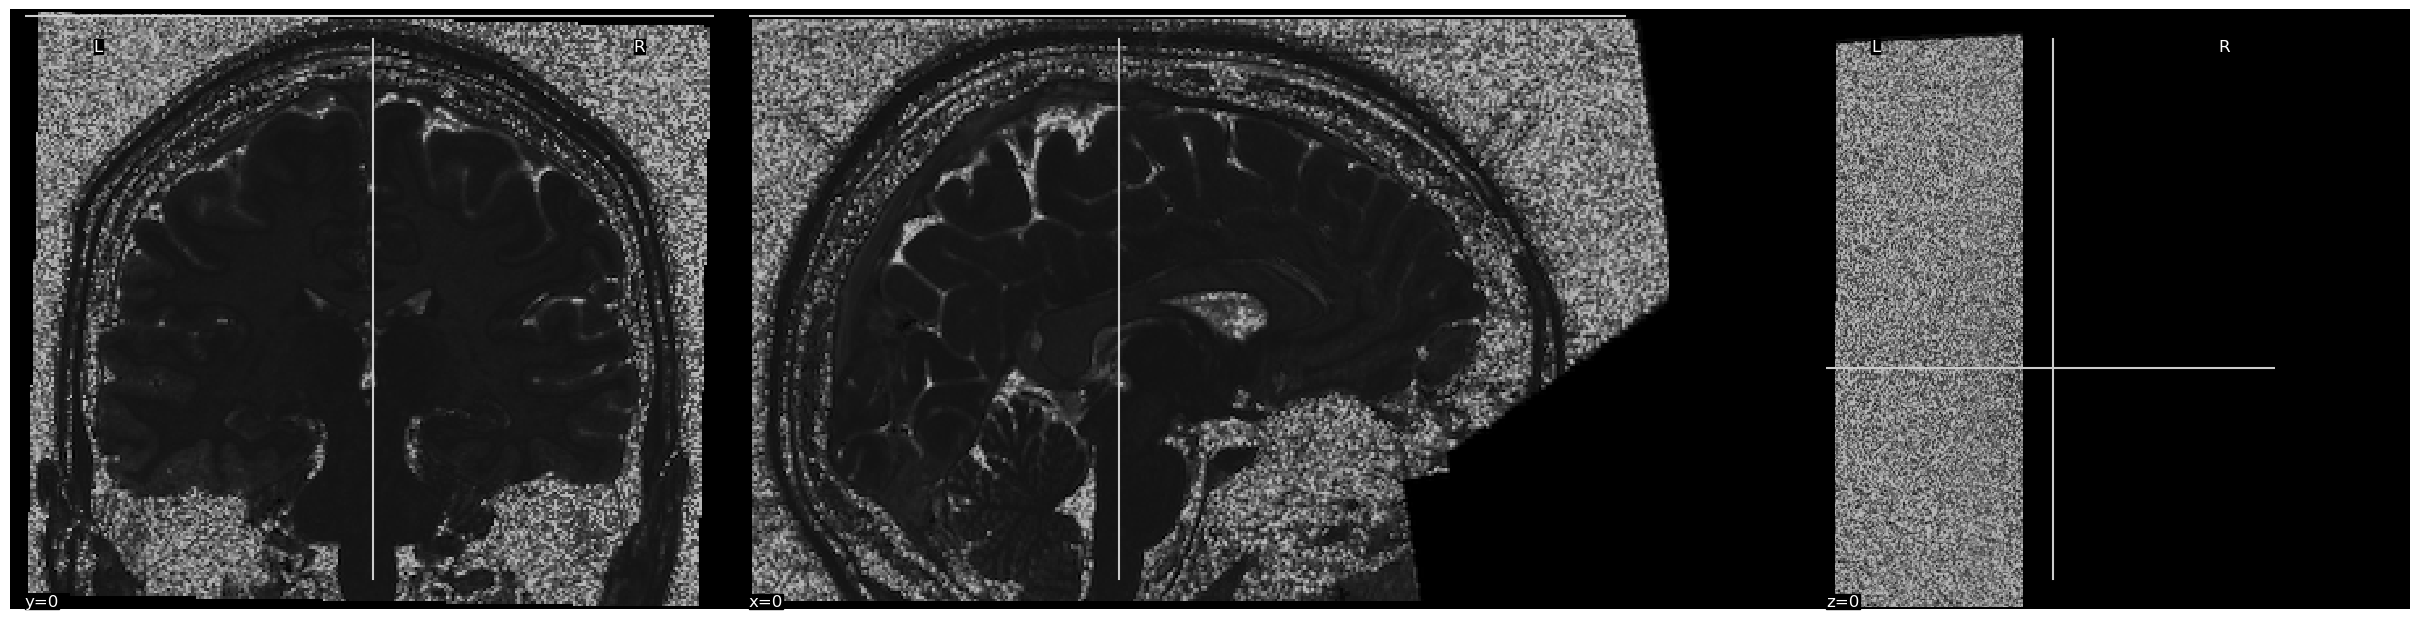

In [9]:
# Plot it
fig = plt.figure(figsize=(24,6))
plotting.plot_anat(fitter.t1, figure=fig, cut_coords=(0,0,0))
plotting.show()